<div style='text-align:center; font-weight:bold; font-size:38px'> Influence on Education Parameter on Country's GDP </div><br>

<div style='text-align:center; font-size:24px'> Hazim Fitri Bin Ahmad Faudzi (P152419) </div><br>

<div style='text-align:center'> Data Management (STQD6324) </div>

<h1 style='font-weight:bold'> 1. Introduction </h1>

<div style='text-align:justify'> This project investigates how some education parameters will effect a country's GDP. This investigation utilize multiple datasets that is publicly available from the worldbank data website https://data.wordbank.org </div>

<h2 style='font-weight:bold'> 1.1 Objectives </h2>

1. To analyze the impact of education parameters on a country's GDP.
2. To identify the relationship between education parameters and GDP.
3. To investigate the trend across income levels and regions towards GDP.

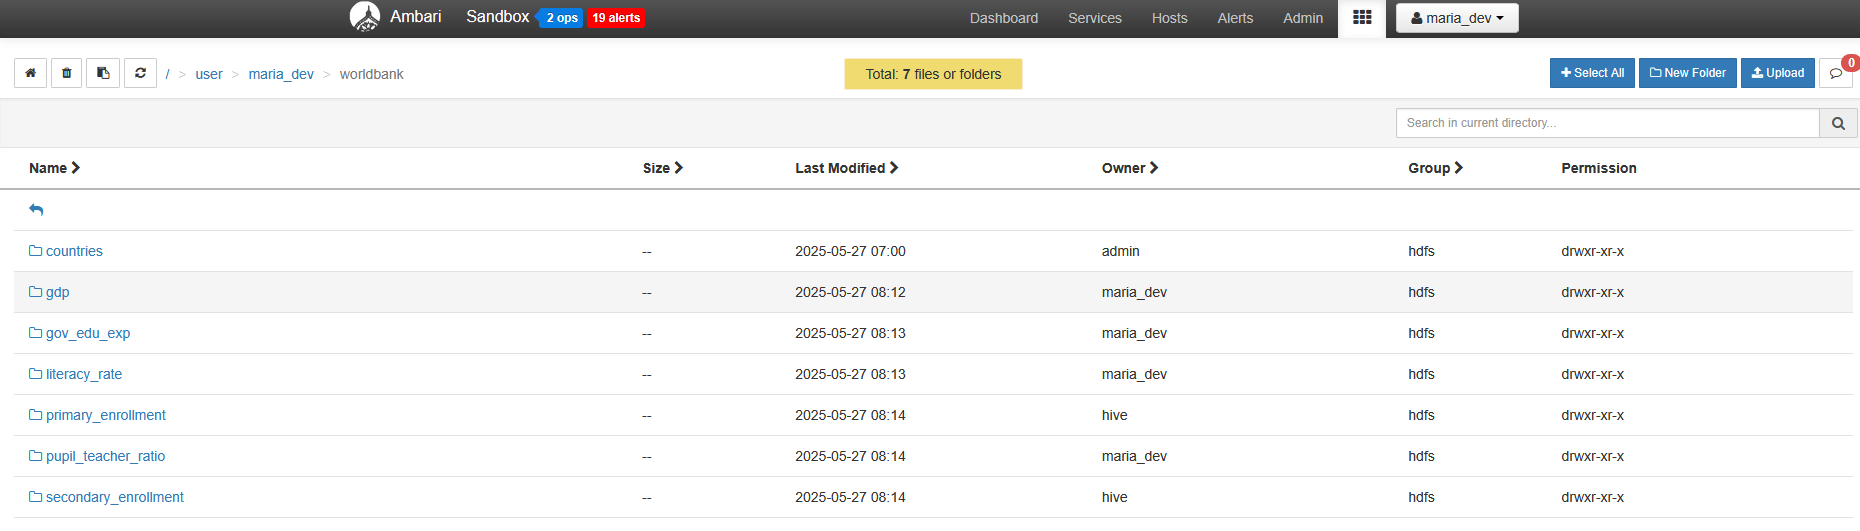

<h1 style='font-weight:bold'> 2. Data Collection </h1>

Datasets obtained from worldbank dataset website includes:
1. GDP per capita (current US$)
2. Government Education Expenditure (% of GDP)
3. Literacy Rate, Adult Total (% of people ages 15 and above)
4. Pupil-Teacher Ratio, Primary
5. School Enrollment, Primary (% gross)
6. School Enrollment, Secondary (% gross)

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyhive import hive
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
# establish a connection to Hive
conn = hive.Connection(
    host='localhost',
    port=10000,
    username='maria_dev'
)

cursor = conn.cursor()

def hive_query(query):
    cursor.execute(query)
    for result in cursor.fetchall():
        print(result)

In [ ]:
# fetching raw data saved in GitHub downloaded from worlbank and remove the first 4 unnecessary rows
gdp = pd.read_csv('https://tinyurl.com/3zhv6cz2', skiprows=4)
edu_exp = pd.read_csv('https://tinyurl.com/bdzmkw8n', skiprows=4)
ptr = pd.read_csv('https://tinyurl.com/36bbjyes', skiprows=4)
pr_enrollment = pd.read_csv('https://tinyurl.com/mr37hpmk', skiprows=4)
sc_enrollment = pd.read_csv('https://tinyurl.com/4kbdw3kb', skiprows=4)
literacy = pd.read_csv('https://tinyurl.com/492krh5h', skiprows=4)

# save the data into csv with suitable format to upload to Hive ('|' as separator to avoid issues with commas in data, remove headers)
gdp.to_csv('data/worldbank/gdp.csv', index=False, header=False, sep='|')
edu_exp.to_csv('data/worldbank/education_expenditure.csv', index=False, header=False, sep='|')
ptr.to_csv('data/worldbank/pupil_teacher_ratio.csv', index=False, header=False, sep='|')
pr_enrollment.to_csv('data/worldbank/primary_enrollment.csv', index=False, header=False, sep='|')
sc_enrollment.to_csv('data/worldbank/secondary_enrollment.csv', index=False, header=False, sep='|')
literacy.to_csv('data/worldbank/literacy_rate.csv', index=False, header=False, sep='|')

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,97.989998,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,71.105171,71.029984,71.495399,72.658661,72.855759,72.638908,72.981560,73.275108,NaN,NaN
2,Afghanistan,AFG,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,37.000000,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,55.465778,56.472198,59.747349,59.553669,59.703239,60.007320,60.290852,60.505550,NaN,NaN
4,Angola,AGO,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,72.400002,NaN,NaN,NaN


In [ ]:
# fetching data (country name, country code, region, and income level) from worldbank API
url = "http://api.worldbank.org/v2/country?format=json&per_page=300"
data = requests.get(url).json()[1]

df = pd.DataFrame([
    {
        'Country': item['name'],
        'ID': item['id'],
        'Region': item['region']['value'],
        'Income Level': item['incomeLevel']['value']
    }
    for item in data
    if item['region']['value'] != 'Aggregates'  # Skip non-countries
])

df.to_csv('data/worldbank/worldbank_countries.csv', index=False, header=False, sep='|')

In [17]:
# Create table for country GDP data in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.gdp (
    country_name STRING,
    country_code STRING,
    indicator_name STRING,
    indicator_code STRING,
    `1960` FLOAT, `1961` FLOAT, `1962` FLOAT, `1963` FLOAT, `1964` FLOAT, `1965` FLOAT, `1966` FLOAT, `1967` FLOAT, `1968` FLOAT, `1969` FLOAT,
    `1970` FLOAT, `1971` FLOAT, `1972` FLOAT, `1973` FLOAT, `1974` FLOAT, `1975` FLOAT, `1976` FLOAT, `1977` FLOAT, `1978` FLOAT, `1979` FLOAT, 
    `1980` FLOAT, `1981` FLOAT, `1982` FLOAT, `1983` FLOAT, `1984` FLOAT, `1985` FLOAT, `1986` FLOAT, `1987` FLOAT, `1988` FLOAT, `1989` FLOAT,
    `1990` FLOAT, `1991` FLOAT, `1992` FLOAT, `1993` FLOAT, `1994` FLOAT, `1995` FLOAT, `1996` FLOAT, `1997` FLOAT, `1998` FLOAT, `1999` FLOAT,
    `2000` FLOAT, `2001` FLOAT, `2002` FLOAT, `2003` FLOAT, `2004` FLOAT, `2005` FLOAT, `2006` FLOAT, `2007` FLOAT, `2008` FLOAT, `2009` FLOAT,
    `2010` FLOAT, `2011` FLOAT, `2012` FLOAT, `2013` FLOAT, `2014` FLOAT, `2015` FLOAT, `2016` FLOAT, `2017` FLOAT, `2018` FLOAT, `2019` FLOAT,
    `2020` FLOAT, `2021` FLOAT, `2022` FLOAT, `2023` FLOAT, `2024` FLOAT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/gdp'
""")

In [18]:
# create table for education expenditure data in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.gov_edu_exp (
    country_name STRING,
    country_code STRING,
    indicator_name STRING,
    indicator_code STRING,
    `1960` FLOAT, `1961` FLOAT, `1962` FLOAT, `1963` FLOAT, `1964` FLOAT, `1965` FLOAT, `1966` FLOAT, `1967` FLOAT, `1968` FLOAT, `1969` FLOAT,
    `1970` FLOAT, `1971` FLOAT, `1972` FLOAT, `1973` FLOAT, `1974` FLOAT, `1975` FLOAT, `1976` FLOAT, `1977` FLOAT, `1978` FLOAT, `1979` FLOAT, 
    `1980` FLOAT, `1981` FLOAT, `1982` FLOAT, `1983` FLOAT, `1984` FLOAT, `1985` FLOAT, `1986` FLOAT, `1987` FLOAT, `1988` FLOAT, `1989` FLOAT,
    `1990` FLOAT, `1991` FLOAT, `1992` FLOAT, `1993` FLOAT, `1994` FLOAT, `1995` FLOAT, `1996` FLOAT, `1997` FLOAT, `1998` FLOAT, `1999` FLOAT,
    `2000` FLOAT, `2001` FLOAT, `2002` FLOAT, `2003` FLOAT, `2004` FLOAT, `2005` FLOAT, `2006` FLOAT, `2007` FLOAT, `2008` FLOAT, `2009` FLOAT,
    `2010` FLOAT, `2011` FLOAT, `2012` FLOAT, `2013` FLOAT, `2014` FLOAT, `2015` FLOAT, `2016` FLOAT, `2017` FLOAT, `2018` FLOAT, `2019` FLOAT,
    `2020` FLOAT, `2021` FLOAT, `2022` FLOAT, `2023` FLOAT, `2024` FLOAT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/gov_edu_exp'
""")

In [19]:
# create table for literacy rate data in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.literacy_rate (
    country_name STRING,
    country_code STRING,
    indicator_name STRING,
    indicator_code STRING,
    `1960` FLOAT, `1961` FLOAT, `1962` FLOAT, `1963` FLOAT, `1964` FLOAT, `1965` FLOAT, `1966` FLOAT, `1967` FLOAT, `1968` FLOAT, `1969` FLOAT,
    `1970` FLOAT, `1971` FLOAT, `1972` FLOAT, `1973` FLOAT, `1974` FLOAT, `1975` FLOAT, `1976` FLOAT, `1977` FLOAT, `1978` FLOAT, `1979` FLOAT, 
    `1980` FLOAT, `1981` FLOAT, `1982` FLOAT, `1983` FLOAT, `1984` FLOAT, `1985` FLOAT, `1986` FLOAT, `1987` FLOAT, `1988` FLOAT, `1989` FLOAT,
    `1990` FLOAT, `1991` FLOAT, `1992` FLOAT, `1993` FLOAT, `1994` FLOAT, `1995` FLOAT, `1996` FLOAT, `1997` FLOAT, `1998` FLOAT, `1999` FLOAT,
    `2000` FLOAT, `2001` FLOAT, `2002` FLOAT, `2003` FLOAT, `2004` FLOAT, `2005` FLOAT, `2006` FLOAT, `2007` FLOAT, `2008` FLOAT, `2009` FLOAT,
    `2010` FLOAT, `2011` FLOAT, `2012` FLOAT, `2013` FLOAT, `2014` FLOAT, `2015` FLOAT, `2016` FLOAT, `2017` FLOAT, `2018` FLOAT, `2019` FLOAT,
    `2020` FLOAT, `2021` FLOAT, `2022` FLOAT, `2023` FLOAT, `2024` FLOAT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/literacy_rate'
""")

In [20]:
# create table for pupil-teacher ratio data in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.pupil_teacher_ratio (
    country_name STRING,
    country_code STRING,
    indicator_name STRING,
    indicator_code STRING,
    `1960` FLOAT, `1961` FLOAT, `1962` FLOAT, `1963` FLOAT, `1964` FLOAT, `1965` FLOAT, `1966` FLOAT, `1967` FLOAT, `1968` FLOAT, `1969` FLOAT,
    `1970` FLOAT, `1971` FLOAT, `1972` FLOAT, `1973` FLOAT, `1974` FLOAT, `1975` FLOAT, `1976` FLOAT, `1977` FLOAT, `1978` FLOAT, `1979` FLOAT, 
    `1980` FLOAT, `1981` FLOAT, `1982` FLOAT, `1983` FLOAT, `1984` FLOAT, `1985` FLOAT, `1986` FLOAT, `1987` FLOAT, `1988` FLOAT, `1989` FLOAT,
    `1990` FLOAT, `1991` FLOAT, `1992` FLOAT, `1993` FLOAT, `1994` FLOAT, `1995` FLOAT, `1996` FLOAT, `1997` FLOAT, `1998` FLOAT, `1999` FLOAT,
    `2000` FLOAT, `2001` FLOAT, `2002` FLOAT, `2003` FLOAT, `2004` FLOAT, `2005` FLOAT, `2006` FLOAT, `2007` FLOAT, `2008` FLOAT, `2009` FLOAT,
    `2010` FLOAT, `2011` FLOAT, `2012` FLOAT, `2013` FLOAT, `2014` FLOAT, `2015` FLOAT, `2016` FLOAT, `2017` FLOAT, `2018` FLOAT, `2019` FLOAT,
    `2020` FLOAT, `2021` FLOAT, `2022` FLOAT, `2023` FLOAT, `2024` FLOAT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/pupil_teacher_ratio'
""")

In [ ]:
# create table for primary school enrollment data in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.primary_enrollment (
    country_name STRING,
    country_code STRING,
    indicator_name STRING,
    indicator_code STRING,
    `1960` FLOAT, `1961` FLOAT, `1962` FLOAT, `1963` FLOAT, `1964` FLOAT, `1965` FLOAT, `1966` FLOAT, `1967` FLOAT, `1968` FLOAT, `1969` FLOAT,
    `1970` FLOAT, `1971` FLOAT, `1972` FLOAT, `1973` FLOAT, `1974` FLOAT, `1975` FLOAT, `1976` FLOAT, `1977` FLOAT, `1978` FLOAT, `1979` FLOAT, 
    `1980` FLOAT, `1981` FLOAT, `1982` FLOAT, `1983` FLOAT, `1984` FLOAT, `1985` FLOAT, `1986` FLOAT, `1987` FLOAT, `1988` FLOAT, `1989` FLOAT,
    `1990` FLOAT, `1991` FLOAT, `1992` FLOAT, `1993` FLOAT, `1994` FLOAT, `1995` FLOAT, `1996` FLOAT, `1997` FLOAT, `1998` FLOAT, `1999` FLOAT,
    `2000` FLOAT, `2001` FLOAT, `2002` FLOAT, `2003` FLOAT, `2004` FLOAT, `2005` FLOAT, `2006` FLOAT, `2007` FLOAT, `2008` FLOAT, `2009` FLOAT,
    `2010` FLOAT, `2011` FLOAT, `2012` FLOAT, `2013` FLOAT, `2014` FLOAT, `2015` FLOAT, `2016` FLOAT, `2017` FLOAT, `2018` FLOAT, `2019` FLOAT,
    `2020` FLOAT, `2021` FLOAT, `2022` FLOAT, `2023` FLOAT, `2024` FLOAT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/primary_enrollment'
""")

In [ ]:
# create table for secondary school enrollment data in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.secondary_enrollment (
    country_name STRING,
    country_code STRING,
    indicator_name STRING,
    indicator_code STRING,
    `1960` FLOAT, `1961` FLOAT, `1962` FLOAT, `1963` FLOAT, `1964` FLOAT, `1965` FLOAT, `1966` FLOAT, `1967` FLOAT, `1968` FLOAT, `1969` FLOAT,
    `1970` FLOAT, `1971` FLOAT, `1972` FLOAT, `1973` FLOAT, `1974` FLOAT, `1975` FLOAT, `1976` FLOAT, `1977` FLOAT, `1978` FLOAT, `1979` FLOAT, 
    `1980` FLOAT, `1981` FLOAT, `1982` FLOAT, `1983` FLOAT, `1984` FLOAT, `1985` FLOAT, `1986` FLOAT, `1987` FLOAT, `1988` FLOAT, `1989` FLOAT,
    `1990` FLOAT, `1991` FLOAT, `1992` FLOAT, `1993` FLOAT, `1994` FLOAT, `1995` FLOAT, `1996` FLOAT, `1997` FLOAT, `1998` FLOAT, `1999` FLOAT,
    `2000` FLOAT, `2001` FLOAT, `2002` FLOAT, `2003` FLOAT, `2004` FLOAT, `2005` FLOAT, `2006` FLOAT, `2007` FLOAT, `2008` FLOAT, `2009` FLOAT,
    `2010` FLOAT, `2011` FLOAT, `2012` FLOAT, `2013` FLOAT, `2014` FLOAT, `2015` FLOAT, `2016` FLOAT, `2017` FLOAT, `2018` FLOAT, `2019` FLOAT,
    `2020` FLOAT, `2021` FLOAT, `2022` FLOAT, `2023` FLOAT, `2024` FLOAT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/secondary_enrollment'
""")

In [25]:
# create table for country metadata in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.countries (
    country_name STRING,
    country_code STRING,
    region STRING,
    income_level STRING
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/countries'
""")

In [37]:
# extracting only desired column from data in Hive
query = """
SELECT c.country_name AS country_name,
       c.country_code AS country_code,
       c.region AS region,
       c.income_level AS income_level,
       g.`2015` AS gdp,
       e.`2015` AS edu_exp,
       l.`2015` AS literacy_rate,
       p.`2015` AS pupil_teacher_ratio,
       pr.`2015` AS primary_enrollment,
       sc.`2015` AS secondary_enrollment
FROM worldbank.countries c
LEFT JOIN worldbank.gdp g 
ON c.country_code = g.country_code
LEFT JOIN worldbank.gov_edu_exp e
ON c.country_code = e.country_code
LEFT JOIN worldbank.literacy_rate l
ON c.country_code = l.country_code
LEFT JOIN worldbank.pupil_teacher_ratio p
ON c.country_code = p.country_code 
LEFT JOIN worldbank.primary_enrollment pr
ON c.country_code = pr.country_code
LEFT JOIN worldbank.secondary_enrollment sc
ON c.country_code = sc.country_code
"""

# read the data queried from Hive into a data frame in Python
df = pd.read_sql(query, conn)

# save the data into csv file to upload into Hive
df.to_csv('data/worldbank/data.csv')

df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_28016\550228556.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,country_name,country_code,region,income_level,gdp,edu_exp,literacy_rate,pupil_teacher_ratio,primary_enrollment,secondary_enrollment
0,Aruba,ABW,Latin America & Caribbean,High income,27458.2250,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,South Asia,Low income,565.5697,3.25580,33.75384,43.38836,106.18242,53.28514
2,Angola,AGO,Sub-Saharan Africa,Lower middle income,3213.9026,3.10000,66.23586,50.02951,119.14226,NaN
3,Albania,ALB,Europe & Central Asia,Upper middle income,3952.8035,3.43797,NaN,18.61557,105.68865,102.44073
4,Andorra,AND,Europe & Central Asia,High income,38654.9340,3.28035,NaN,9.93795,88.95535,92.54580


<h1 style='font-weight:bold'> 3. Data Cleaning </h1>

<h2 style='font-weight:bold'> 3.1 Handling missing data </h2> 

In [29]:
# inspect null values in the data
df.isnull().sum()

country_name              0
country_code              0
region                    0
income_level              0
gdp                       6
edu_exp                  51
literacy_rate           172
pupil_teacher_ratio      75
primary_enrollment       40
secondary_enrollment     63
dtype: int64

In [30]:
# drop rows where GDP is missing
df_drop_missing_gdp = df[df['gdp'].notnull()]

# drop literacy rate due to too many missing values
df_clean2 = df_drop_missing_gdp.drop(columns=['literacy_rate'])

# re-inspect null values in the cleaned data
df_clean2.isnull().sum()

country_name             0
country_code             0
region                   0
income_level             0
gdp                      0
edu_exp                 46
pupil_teacher_ratio     72
primary_enrollment      37
secondary_enrollment    61
dtype: int64

In [31]:
# copy currently cleaned data to a new DataFrame
df_clean3 = df_clean2.copy()

# define all nummeric columns
numeric_cols = df_clean3.select_dtypes(include='float64').columns.tolist()

# fill missing values in numeric columns with the median of each column grouped by region
for col in numeric_cols:
    df_clean3[col] = df_clean3.groupby('region')[col].transform(lambda x: x.fillna(x.median()))

# re-inspect null values in the final cleaned data
df_clean3.isnull().sum()

# copy the final cleaned data to a new DataFrame for further analysis (rename purpose)
cleaned_df = df_clean3.copy()

<h2 style='font-weight:bold'> 3.2 Handling Duplicate Rows </h2>

In [32]:
# check for duplicated data
cleaned_df.duplicated().sum()

0

<h2 style='font-weight:bold'> 3.3 Handling Outliers </h2>

<h1 style='font-weight:bold'> 4. Exploratory Data Analysis </h1>

<h2 style='font-weight:bold'> 4.1 Summary Statistics </h2>

In [34]:
# view the statistical summary for both numeric and categorical variables
cleaned_df.describe(include='all')

,country_name,country_code,region,income_level,gdp,edu_exp,pupil_teacher_ratio,primary_enrollment,secondary_enrollment
count,211,211,211,211,211.000000,211.000000,211.000000,211.000000,211.000000
unique,211,211,7,4,NaN,NaN,NaN,NaN,NaN
top,Aruba,ABW,Europe & Central Asia,High income,NaN,NaN,NaN,NaN,NaN
freq,1,1,57,82,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,17046.169039,4.449362,21.794284,102.718159,85.921168
std,NaN,NaN,NaN,NaN,25262.774748,1.643213,11.449027,10.891014,27.164391
min,NaN,NaN,NaN,NaN,280.966830,0.436955,7.845240,52.786980,11.230950
25%,NaN,NaN,NaN,NaN,2196.108000,3.441233,13.246210,98.612180,74.003088
50%,NaN,NaN,NaN,NaN,6154.496000,4.242013,16.997470,102.214330,93.968200
75%,NaN,NaN,NaN,NaN,20513.037500,4.982337,27.254865,106.085625,102.279175


<h2 style='font-weight:bold'> 4.2 Relationship Between GDP and Education Metrics </h2>

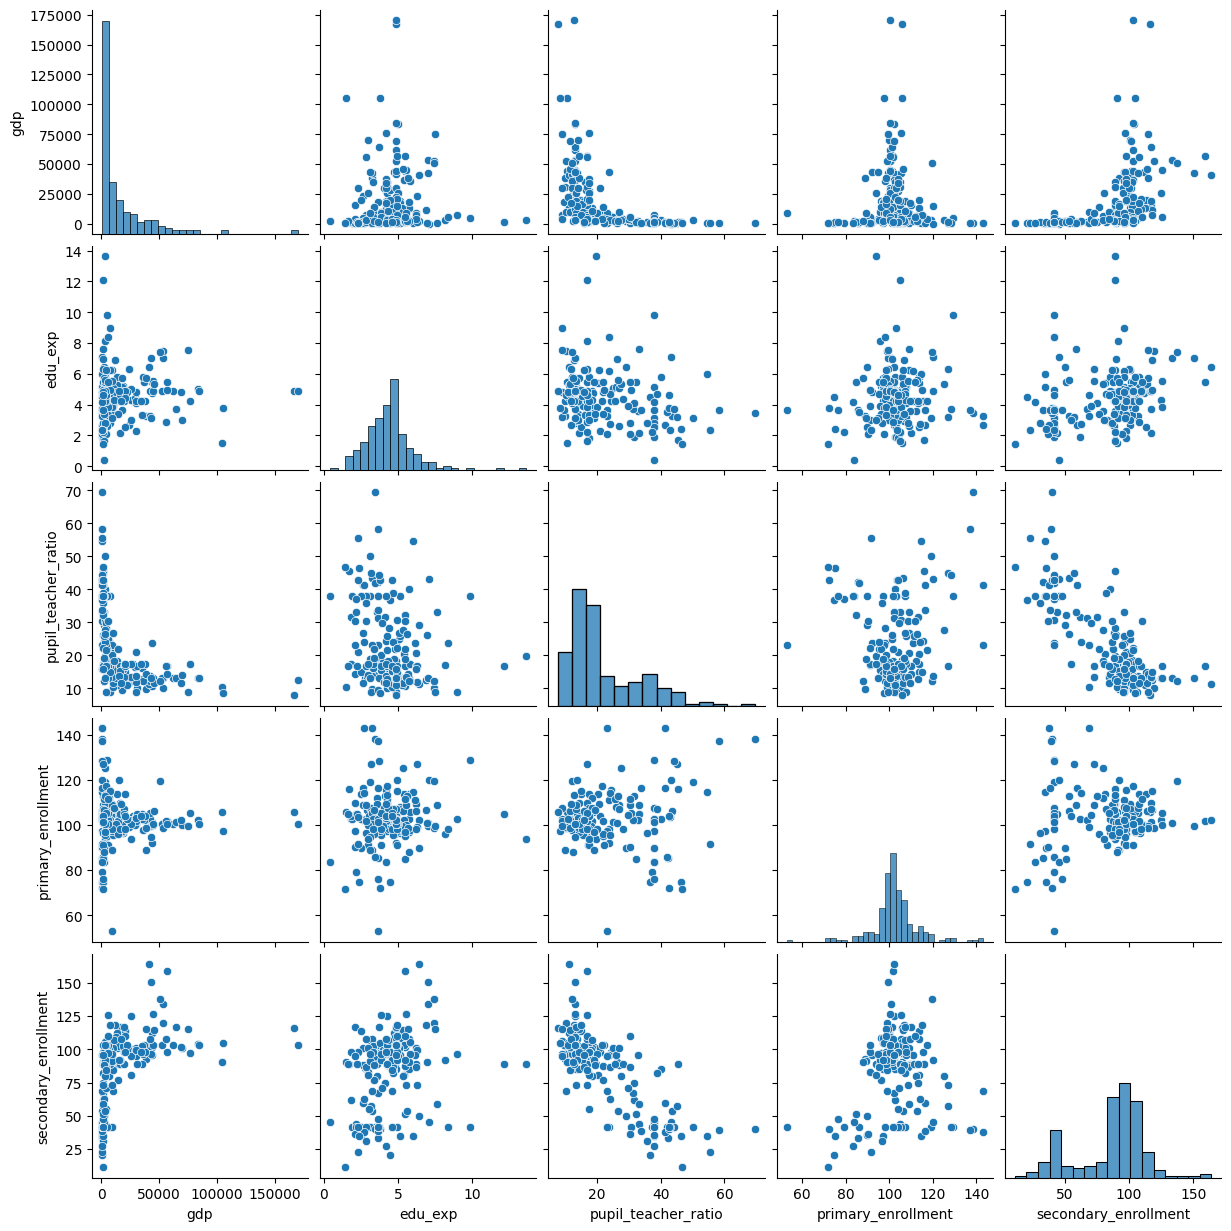

In [35]:
# plot a pairplot to visualize relationships between numeric variables
sns.pairplot(cleaned_df[numeric_cols]);

<div style='text-align:justify'> A pairplot was utilized to explore the relationships among key numeric indicators: GDP, education expenditure (edu_exp), pupil-teacher ratio, primary enrollment, and secondary enrollment. This visualization provides an initial exploratory view to identify patterns and dependencies relevant to national economic and educational performance. </div><br>


<div style='text-align:justify; font-weight:bold'> GDP and Education Indicators </div>
<div style='text-align:justify'> The analysis reveals a positive association between GDP and secondary enrollment. Countries with greater participation in secondary education tend to report higher GDP levels. This finding is consistent with previous research suggesting that human capital accumulation, particularly through secondary education, contributes significantly to economic productivity and growth (Barro, 2001; Hanushek & Woessmann, 2008). A notable negative correlation is also observed between GDP and pupil-teacher ratio, indicating that wealthier countries often maintain lower class sizes, supporting better educational outcomes (UNESCO, 2014). Moreover, GDP and education expenditure show a mild positive trend, reinforcing the notion that high-income countries allocate a larger proportion of resources toward education (World Bank, 2018). </div><br>

<div style='text-align:justify; font-weight:bold'> Intra-Education Variable Relationships </div>
<div style='text-align:justify'> The strong positive relationship between primary and secondary enrollment suggests a systemic alignment in educational continuity. This reflects the strength of national education systems where robust foundational access enables progression to higher educational levels (OECD, 2016). In contrast, education expenditure does not exhibit a strong linear relationship with either enrollment or pupil-teacher ratio. This discrepancy points to the influence of non-monetary factors such as policy effectiveness, governance, and social barriers, which can mediate the impact of spending on actual educational outcomes (UNESCO GEM Report, 2021). </div><br>

<div style='text-align:justify; font-weight:bold'> Implications for Policy and Development </div>
<div style='text-align:justify'> These insights underscore the importance of targeted investment in secondary education and teacher availability as levers for long-term economic advancement. Governments in developing regions should prioritize efficiency in fund allocation, accompanied by systemic reforms to ensure that education expenditure translates into tangible improvements in access and quality. As highlighted by Hanushek and Woessmann (2010), the effectiveness of education systems—not just their funding levels—determines the scale of economic returns. </div>

<h2 style='font-weight:bold'> 4.3 GDP Distribution by Income Level </h2>

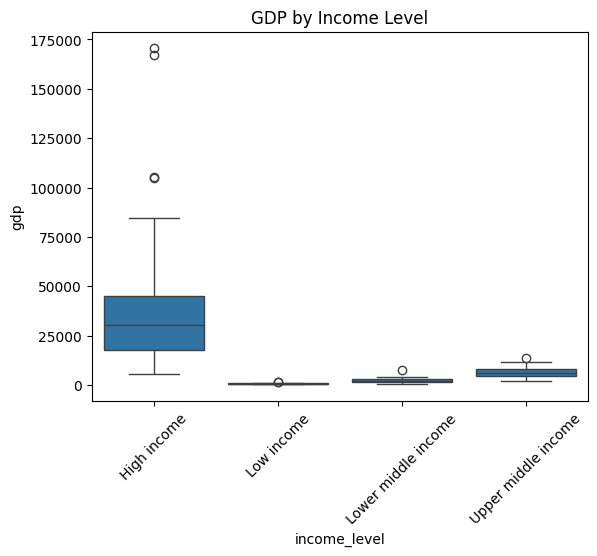

In [43]:
# plot a boxplot of GDP by income level
sns.boxplot(data=cleaned_df, x='income_level', y='gdp')
plt.title('GDP by Income Level')
plt.xticks(rotation=45);

<div style='text-align:justify; font-weight:bold'> GDP Distribution by Income Level </div>
<div style='text-align:justify'>To further explore economic disparities, a boxplot was constructed comparing the distribution of GDP across the four World Bank-defined income classifications: high income, upper middle income, lower middle income, and low income. This visualization provides a clear depiction of both central tendencies and dispersion within each group. </div><br>

<div style='text-align:justify; font-weight:bold'> Insights and Explanation </div>
The plot demonstrates a stark economic divide among countries grouped by income level:

<div style='text-align:justify'> High-Income Countries: This group exhibits the highest median GDP and the widest range. Several high-income countries stand out as outliers with extremely high GDP values, reflecting global economic leaders such as the United States and Switzerland. The wide interquartile range (IQR) indicates considerable variability within this group. </div><br>

<div style='text-align:justify'> Upper Middle and Lower Middle Income: These two categories show moderate median GDP values but are tightly clustered, suggesting relatively less internal variation. This reflects some degree of economic convergence within these groups. </div> <br>

<div style='text-align:justify'> Low-Income Countries: Countries in this category have the lowest median GDP with minimal spread. The compact distribution highlights limited economic capacity and narrow disparity among these nations. </div><br>

<div style='text-align:justify'> This stratified economic structure is aligned with global development literature. The World Bank (2023) and UNDP (2021) have long reported such divides, often tied to differences in institutional quality, access to capital, trade infrastructure, and investment in human capital. </div><br>

<div style='text-align:justify; font-weight:bold'> Policy Implications </div>
<div style='text-align:justify'> The visualization underscores the developmental challenge faced by low-income nations. With limited GDP and minimal variation, these countries may struggle to invest in public services such as education, healthcare, and infrastructure. Targeted aid, international partnerships, and sustainable development strategies are crucial for improving fiscal capacity in these regions. Conversely, high-income nations should prioritize equitable redistribution and support for low-income partners to promote inclusive growth. </div><br>

<h2 style='font-weight:bold'> 4.4 Correlation Matrix of Economic and Education Indicators </h2>

<Axes: >

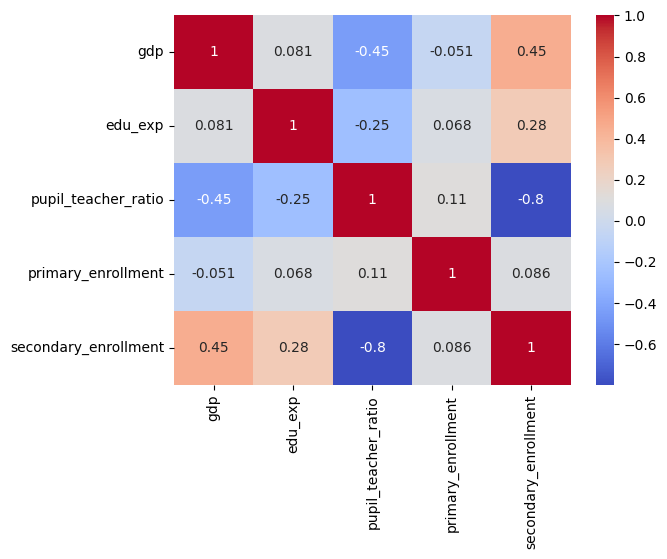

In [ ]:
# plot a heatmap of correlations between numeric variables
sns.heatmap(cleaned_df[numeric_cols].corr(), annot=True, cmap='coolwarm');

<div style='text-align:justify; font-weight:bold'> Correlation Analysis of Education and Economic Indicators </div>
<div style='text-align:justify'> To quantify the linear relationships among key numeric variables, a correlation heatmap was generated. The correlation coefficient (ranging from -1 to 1) indicates the strength and direction of linear association between pairs of variables. </div> <br>

<div style='text-align:justify; font-weight: bold'>Insights and Explanation </div>
<div style='text-align:justify'>GDP and Secondary Enrollment: A moderate positive correlation (r = 0.45) was found, indicating that higher secondary school enrollment is associated with greater GDP levels. This supports literature linking secondary education to human capital development and long-term economic productivity (Barro, 2001; Hanushek & Woessmann, 2010). </div> <br>

<div style='text-align:justify'>GDP and Pupil-Teacher Ratio: A negative correlation (r = -0.45) suggests that countries with lower pupil-teacher ratios (i.e., more teachers per student) tend to have higher GDPs. This reflects the importance of teacher availability in enhancing education quality and, consequently, economic growth (UNESCO, 2014). </div> <br>

<div style='text-align:justify'>Secondary Enrollment and Pupil-Teacher Ratio: A strong negative correlation (r = -0.80) implies that high secondary enrollment rates are typically found in countries with lower pupil-teacher ratios, reinforcing the significance of sufficient teaching staff in supporting sustained educational engagement. </div> <br>

<div style='text-align:justify'>Education Expenditure Relationships: Education expenditure shows weak to moderate positive correlations with GDP (r = 0.081), secondary enrollment (r = 0.28), and pupil-teacher ratio (r = -0.25). Although the correlations are modest, they suggest that expenditure has some influence on outcomes, but its impact may be moderated by policy implementation, quality of governance, and systemic efficiency (World Bank, 2018). </div> <br>

<div style='text-align:justify'>Primary vs. Secondary Enrollment: Surprisingly, only a weak correlation exists between primary and secondary enrollment (r = 0.086), suggesting a potential drop-off or bottleneck in educational progression, especially in lower-income regions. This highlights the need for focused policy interventions to ensure educational continuity.</div> <br>

<div style='text-align:justify; font-weight:bold'>Implications for Policy </div>
<div style='text-align:justify'>The correlation analysis affirms the interdependence of educational quality, access, and economic development. In particular, improving pupil-teacher ratios and boosting secondary enrollment appear central to enhancing GDP outcomes. Meanwhile, the modest correlation of education expenditure with outcome variables suggests that fiscal inputs must be complemented with effective planning and oversight to yield meaningful impact. </div>

<h2 style='font-weight:bold'> 4.5 GDP Variation Across Pupil-Teacher Ratio Levels </h2>

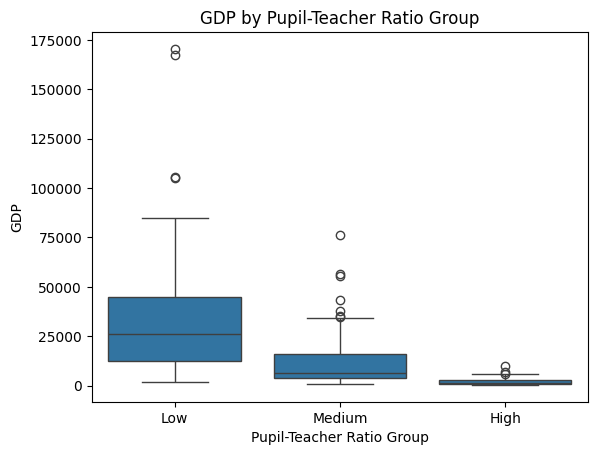

In [44]:
# plot a boxplot of GDP by level of pupil-teacher ratio
cleaned_df['ptr_group'] = pd.cut(cleaned_df['pupil_teacher_ratio'], bins=[0,15,25,40], labels=['Low','Medium','High'])
sns.boxplot(data=cleaned_df, x='ptr_group', y='gdp')
plt.title('GDP by Pupil-Teacher Ratio Group')
plt.xlabel('Pupil-Teacher Ratio Group')
plt.ylabel('GDP');

<div style='text-align:justify; font-weight:bold;'> GDP Distribution Across Pupil-Teacher Ratio Groups </div>
<div style='text-align:justify'> To examine the influence of teacher availability on national economic performance, countries were grouped into three categories—Low, Medium, and High—based on their pupil-teacher ratios (PTR). A boxplot was generated to visualize the distribution of GDP within each group, offering insights into how teacher density may be associated with economic output. </div> <br>

<div style='text-align:justify; font-weight:bold'>Insights and Explanation </div> 
<div style='text-align:justify'>Low PTR Group: Countries in this group, which have a higher teacher-to-student ratio (i.e., fewer students per teacher), display the highest median GDP and the widest spread. Numerous outliers are present, suggesting that several economically advanced countries fall into this category. The wide interquartile range (IQR) indicates considerable GDP variation even among well-staffed education systems. </div> <br>

<div style='text-align:justify'>Medium PTR Group: This group shows a lower median GDP than the low PTR group, though still with noticeable variation. The presence of several high-GDP outliers suggests some economic heterogeneity, possibly due to regional policy differences or resource allocation strategies. </div> <br>

<div style='text-align:justify'>High PTR Group: Representing countries with overcrowded classrooms and limited teacher availability, this group exhibits the lowest median GDP and a compressed distribution. The narrow IQR and minimal outliers suggest structural limitations in education systems that likely constrain economic development. </div> <br>

<div style='text-align:justify'>These findings are consistent with educational development theory, which asserts that student-teacher ratios significantly impact learning quality, student retention, and long-term productivity (UNESCO, 2014; Hanushek & Rivkin, 2006). Low PTRs enable more individualized attention, which fosters better learning outcomes and contributes to a more capable workforce, thus enhancing national income. </div> <br>

<div style='text-align:justify; font-weight:bold'>Implications for Policy and Development </div>
<div style='text-align:justify'>The analysis highlights the importance of investing in human resources within education systems. Reducing pupil-teacher ratios—particularly in low-income or high-PTR nations—may yield long-term economic dividends. Policymakers should consider this as a strategic investment, ensuring that educational quality is not compromised by overcrowding. Targeted recruitment, teacher training, and equitable distribution of teaching personnel are essential for bridging the gap between education and economic performance. </div>

<h2 style='font-weight:bold'> 4.6 Top 10 Country with Highest GDP: Economic Powerhouses </h2>

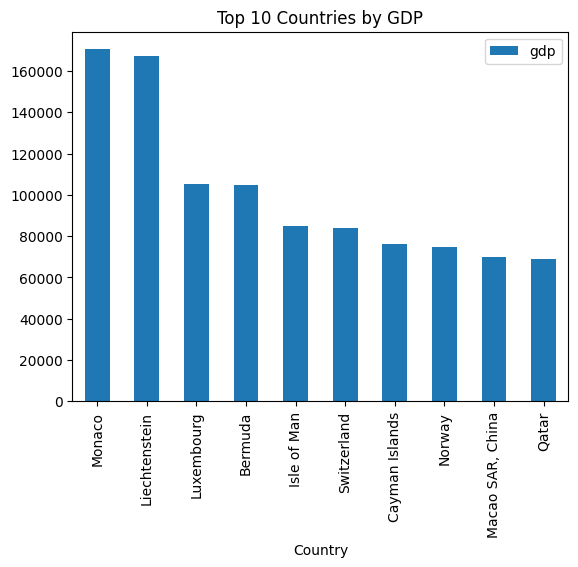

In [45]:
# plot a barplot of the top 10 countries by GDP
top10 = cleaned_df.sort_values('gdp', ascending=False).head(10)
top10.plot(kind='bar', x='country_name', y=['gdp'])
plt.title('Top 10 Countries by GDP')
plt.xlabel('Country');

<div style='text-align:justify; font-weight:bold'> Top 10 Countries by GDP </div>
<div style='text-align:justify'> A bar chart was generated to visualize the top 10 countries in terms of gross domestic product (GDP). This representation enables clear identification of global economic leaders and facilitates comparative analysis across nations with the highest economic output per capita.</div> <br>

<div style='text-align:justify; font-weight:bold'>Insights and Explanation</div>
<div style='text-align:justify'> Top Performers: Monaco and Liechtenstein dominate the chart with GDP values exceeding USD 160,000. These countries are characterized by specialized high-income economies, favorable tax regimes, and limited population sizes, which significantly elevate their per capita income.</div><br>

<div style='text-align:justify'> Luxembourg, Bermuda, and Isle of Man also report extremely high GDP, driven by their roles as financial hubs and offshore centers. Their service-based economies attract multinational corporations and wealthy investors, inflating GDP figures despite their small geographic and demographic footprints.</div><br>

<div style='text-align:justify'> Switzerland and Norway, known for their stability, advanced infrastructure, and innovation-driven economies, also appear prominently. These nations benefit from strong industrial sectors (e.g., pharmaceuticals in Switzerland, energy in Norway) and well-developed public services.</div><br>

<div style='text-align:justify'> Qatar and Macao SAR (China) are resource-rich or tourism-driven economies. Qatar, in particular, leverages its vast natural gas reserves, while Macao benefits from its position as a global gambling and entertainment center.</div><br>

<div style='text-align:justify'> This pattern reflects the findings of the International Monetary Fund (IMF, 2023) and World Bank (2023), which routinely list these nations among the top performers in terms of per capita GDP due to economic specialization, high productivity, and favorable regulatory environments.</div><br>

<div style='text-align:justify; font-weight:bold'> Implications for Policy and Research</div>
<div style='text-align:justify'> These countries illustrate that strategic sectoral focus—whether finance, energy, tourism, or industry—combined with sound governance and global integration, can lead to exceptional economic outcomes. However, such high GDP figures may not necessarily reflect broad-based development, as income inequality and dependency on niche sectors can pose long-term sustainability challenges. For developing nations, the lesson lies in fostering high-value sectors, attracting investment, and building resilient, knowledge-driven economies.</div>

<h2 style='font-weight:bold'> 4.7 Top 10 Countries with Highest Education Expenditure </h2>

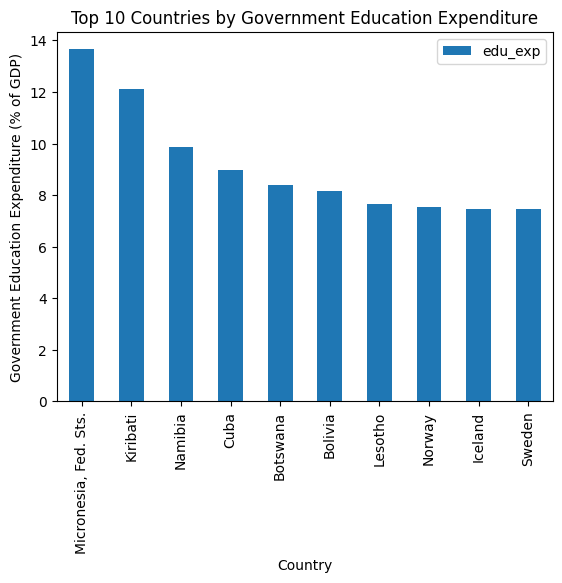

In [48]:
# plot a barplot of the top 10 countries by government education expenditure
top10 = cleaned_df.sort_values('edu_exp', ascending=False).head(10)
top10.plot(kind='bar', x='country_name', y=['edu_exp'])
plt.title('Top 10 Countries by Government Education Expenditure')
plt.xlabel('Country')
plt.ylabel('Government Education Expenditure (% of GDP)');

<div style='text-align:justify'>The bar chart presents the top 10 countries with the highest education expenditure as a percentage of GDP. This metric reflects the prioritization of education within national budgets and can serve as a proxy for commitment to human capital development.</div> <br>

<div style='text-align:justify'>Leading Nations: Micronesia (Fed. Sts.), Kiribati, and Namibia top the chart, with education expenditure exceeding 10% of GDP. These nations, often categorized as developing or small island economies, demonstrate a substantial fiscal commitment to education despite constrained economic resources. Their high spending may reflect efforts to improve human capital as a long-term development strategy.</div><br>

<div style='text-align:justify'>Middle Group: Countries such as Cuba, Botswana, and Bolivia also allocate a significant portion of their GDP to education. For instance, Cuba’s emphasis on universal education and teacher training is well-documented and continues to be a cornerstone of its social policy (Carnoy, 2007).</div><br>

<div style='text-align:justify'>High-Income Representation: Notably, high-income nations like Norway, Iceland, and Sweden also appear in the top 10. Although their percentages are slightly lower, these countries have larger GDP bases, meaning that their absolute investment in education remains substantial. Their systems are known for accessibility, equity, and quality, often ranking highly in global education indices (OECD, 2022).</div><br>

<div style='text-align:justify'>This diversity in representation suggests that high education expenditure is not exclusive to wealthy nations; rather, it reflects a strategic national priority across income levels. However, high expenditure alone does not guarantee educational outcomes, which are also influenced by efficiency, governance, and contextual factors (UNESCO GEM Report, 2021).</div><br>

<div style='text-align:justify; font-weight:bold'>Implications for Policy</div>
<div style='text-align:justify'>The data underscores the need for sustained investment in education as a means of fostering inclusive development. For low- and middle-income countries, high education spending must be matched with effective implementation to maximize returns. For high-income countries, continued investment is necessary to maintain quality and adapt to evolving labor market demands.</div>

<h1 style='font-weight:bold'> 6. Recommendations </h1>

<div style='text-align:justify'>Based on the findings from the exploratory analysis and statistical evaluation, the following recommendations are proposed to enhance educational outcomes and foster economic development: </div> <br>

<div style='text-align:justify'> 1. Prioritize Investment in Secondary Education
A consistent positive correlation between secondary enrollment and GDP suggests that countries should focus not only on primary education but also on expanding and improving access to secondary education. Governments should:</div>

* Implement policies that reduce dropout rates.

* Provide targeted financial support for lower-income households.

* Invest in infrastructure and curriculum development at the secondary level.

<div style='text-align:justify'>2. Reduce Pupil-Teacher Ratios through Strategic Hiring
The negative correlation between pupil-teacher ratio and both GDP and secondary enrollment highlights the importance of teacher availability. To improve learning outcomes:</div>

* Recruit and train more qualified teachers, especially in underserved areas.

* Provide incentives to retain skilled educators.

* Balance teacher distribution across urban and rural regions.

<div style='text-align:justify'> 3. Ensure Efficient Use of Education Expenditure
While some countries spend a high percentage of GDP on education, the impact on outcomes varies. Efficiency and governance play critical roles. It is recommended to:</div>

* Conduct regular audits of education budgets.

* Align spending with evidence-based programs.

* Use data-driven monitoring to assess the effectiveness of educational investments.

<div style='text-align:justify'>4. Strengthen Education-Policy Linkage with Economic Planning
Educational planning should be aligned with national development strategies. Countries must:</div>

* Forecast labor market needs and adapt curricula accordingly.

* Foster public-private partnerships to bridge education and industry requirements.

* Integrate digital literacy and vocational skills in school systems.

<div style='text-align:justify'> 5. Support International Collaboration and Knowledge Sharing
Countries with strong education systems and high GDP (e.g., Norway, Switzerland) can provide valuable policy models. Emerging economies should:</div>

* Engage in global benchmarking.

* Participate in regional education forums.

* Adopt best practices through bilateral or multilateral cooperation.

<h1 style='font-weight:bold'> 8. Conclusion </h1>

<div style='text-align:justify'>This study examined the relationship between educational indicators and economic performance across various countries, drawing on publicly available global datasets. Through rigorous data cleaning, exploratory data analysis, and statistical modeling, the project revealed several significant patterns linking education to national economic output. </div><br>

<div style='text-align:justify'>Key findings indicate that higher levels of secondary enrollment and lower pupil-teacher ratios are associated with increased GDP. Moreover, countries that allocate a larger proportion of their GDP to education tend to show stronger human capital development, although the efficiency of expenditure remains a crucial determinant of success.</div><br>

<div style='text-align:justify'>The analysis also highlighted the disparities in economic and educational conditions across income groups. High-income countries consistently outperform others in both educational access and GDP levels, while several low- and middle-income countries demonstrate commendable education spending despite economic limitations.</div><br>

<div style='text-align:justify'>Overall, the results emphasize the strategic role of education in shaping long-term economic outcomes. Policymakers are encouraged to invest in quality education systems, reduce structural barriers to learning, and ensure that fiscal efforts translate into effective educational delivery. These actions are vital for achieving equitable growth, improving workforce quality, and fostering national resilience in a rapidly evolving global economy.</div>



<h1 style='font-weight:bold'> 9. References </h1> <br>

1. 


1. Barro, R. J. (2001). Human Capital and Growth. American Economic Review, 91(2), 12–17.

2. Hanushek, E. A., & Woessmann, L. (2008). The role of cognitive skills in economic development. Journal of Economic Literature, 46(3), 607–668.

3. Hanushek, E. A., & Woessmann, L. (2010). The Economics of International Differences in Educational Achievement. NBER Working Paper No. 15949.

4. OECD. (2016). Education at a Glance 2016: OECD Indicators. OECD Publishing.

5. UNESCO. (2014). Teaching and Learning: Achieving Quality for All. EFA Global Monitoring Report.

6. UNESCO GEM Report. (2021). Non-state actors in education: Who chooses? Who loses?

7. World Bank. (2018). World Development Report: Learning to Realize Education’s Promise.

World Bank. (2023). World Development Indicators. https://databank.worldbank.org/source/world-development-indicators

UNDP. (2021). Human Development Report 2021/2022: Uncertain Times, Unsettled Lives. United Nations Development Programme.

Milanovic, B. (2016). Global Inequality: A New Approach for the Age of Globalization. Harvard University Press.

Barro, R. J. (2001). Human Capital and Growth. American Economic Review, 91(2), 12–17.

Hanushek, E. A., & Woessmann, L. (2010). The Economics of International Differences in Educational Achievement. NBER Working Paper No. 15949.

UNESCO. (2014). Teaching and Learning: Achieving Quality for All. EFA Global Monitoring Report.

World Bank. (2018). World Development Report: Learning to Realize Education’s Promise.